In [1]:
import pandas as pd
import hopsworks
import joblib
import datetime
#import dataframe_image as df1
from datetime import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

project = hopsworks.login()
fs = project.get_feature_store()

Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ········
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/39062
Connected. Call `.close()` to terminate connection gracefully.


In [2]:
mr = project.get_model_registry()
model = mr.get_model('bank_note', version=1)
model_dir = model.download()
model = joblib.load(model_dir + '/bank_note_model.pkl')

Connected. Call `.close()` to terminate connection gracefully.

In [3]:
feature_view = fs.get_feature_view(name='bank_notes_dataframe', version=1)

In [4]:
batch_data = feature_view.get_batch_data()
predictions = model.predict(batch_data)

2023-05-05 15:58:27,723 INFO: USE `bwhiz_featurestore`
2023-05-05 15:58:28,510 INFO: SELECT `fg0`.`variance` `variance`, `fg0`.`skewness` `skewness`, `fg0`.`curtosis` `curtosis`, `fg0`.`entropy` `entropy`
FROM `bwhiz_featurestore`.`bank_notes_dataframe_1` `fg0`


In [5]:
predictions

array([1, 1, 1, ..., 0, 1, 0])

In [6]:
batch_data

,variance,skewness,curtosis,entropy
0,0.224320,-0.521470,-0.403860,1.201700
1,-2.298700,-5.227000,5.630000,0.917220
2,-4.504600,-5.812600,10.886700,-0.528460
3,3.966300,10.168400,-4.113100,-4.605600
4,-2.280400,-0.306260,1.334700,1.376300
...,...,...,...,...
1351,-6.418994,-7.426068,6.408040,-7.074906
1352,0.190866,-9.013934,12.876131,-6.655147
1353,-0.194709,-2.618158,14.769632,-2.670950
1354,-4.224041,6.704390,-2.300550,-3.051492


In [7]:
# prediciton on the last bank note sent :
latest_bank_note = predictions[predictions.size - 1]

In [8]:
latest_bank_note

0

In [9]:
bank_note_fg = fs.get_feature_group(name='bank_notes_dataframe', version=1)
df = bank_note_fg.read()
df

2023-05-05 15:58:34,378 INFO: USE `bwhiz_featurestore`
2023-05-05 15:58:35,233 INFO: SELECT `fg0`.`variance` `variance`, `fg0`.`skewness` `skewness`, `fg0`.`curtosis` `curtosis`, `fg0`.`entropy` `entropy`, `fg0`.`output` `output`
FROM `bwhiz_featurestore`.`bank_notes_dataframe_1` `fg0`


,variance,skewness,curtosis,entropy,output
0,0.224320,-0.521470,-0.403860,1.201700,1
1,-2.298700,-5.227000,5.630000,0.917220,1
2,-4.504600,-5.812600,10.886700,-0.528460,1
3,3.966300,10.168400,-4.113100,-4.605600,0
4,-2.280400,-0.306260,1.334700,1.376300,1
...,...,...,...,...,...
1351,-6.418994,-7.426068,6.408040,-7.074906,1
1352,0.190866,-9.013934,12.876131,-6.655147,1
1353,-0.194709,-2.618158,14.769632,-2.670950,1
1354,-4.224041,6.704390,-2.300550,-3.051492,0


In [10]:
### getting the actual label of the last row of data:
label = df.iloc[-1]['output']
label

1.0

In [11]:
monitor_fg = fs.get_or_create_feature_group(name = 'bank_note_predictions',
                                           version = 1,
                                           primary_key = ['datetime'],
                                           description = 'bank note prediction/output Monitoring')

In [12]:
now = datetime.now().strftime("%m/%d/%y, %H:%M:%S")

data = {
    'prediction' : [int(latest_bank_note)],
    'label' : [label],
    'datetime' :[now]
}

monitor_df = pd.DataFrame(data)
monitor_fg.insert(monitor_df)

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/39062/jobs/named/bank_note_predictions_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x1f6ead7f8b0>, None)

In [13]:
history_df = monitor_fg.read()
history_df

2023-05-05 15:59:47,879 INFO: USE `bwhiz_featurestore`
2023-05-05 15:59:48,675 INFO: SELECT `fg0`.`prediction` `prediction`, `fg0`.`label` `label`, `fg0`.`datetime` `datetime`
FROM `bwhiz_featurestore`.`bank_note_predictions_1` `fg0`


,prediction,label,datetime
0,1,1.0,"05/05/23, 05:44:20"
1,0,1.0,"05/05/23, 04:50:20"
2,0,1.0,"05/05/23, 04:56:39"
3,1,0.0,"05/05/23, 10:09:50"
4,0,1.0,"05/05/23, 14:02:05"
5,0,1.0,"05/05/23, 15:58:38"


In [14]:
df_recent = history_df.tail(5)

In [16]:
#df1.export(df_recent, 'assets/df_recent.png') #save an image of the dataframe's last five output

In [15]:
predictions = history_df['prediction']
labels = history_df['label']

results = confusion_matrix(labels, predictions)
print(results)

[[0 1]
 [4 1]]


In [21]:
script_dir = os.getcwd()

In [22]:
assets_dir = os.path.join(script_dir, '..', 'assets')

In [23]:
assets_dir

'C:\\Users\\HP\\python_folder\\serverless-ml-projects\\Authenticating-Bank-Notes-as-a-Serverless-ML-System\\src\\..\\assets'

In [24]:
if not os.path.exists(assets_dir):
    os.makedirs(assets_dir)

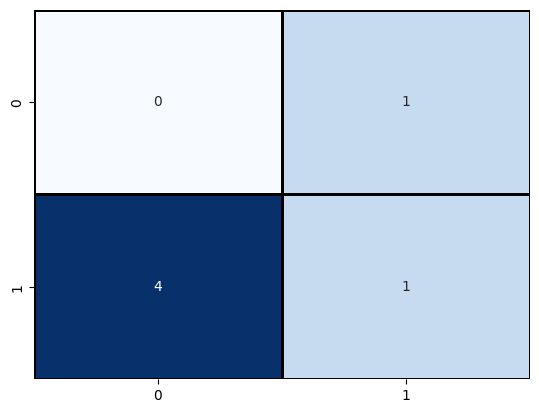

In [25]:
try:
    if results.shape == (2,2):
        cm = sns.heatmap(results, annot=True, fmt='',
            linecolor='k',linewidths=1,cmap='Blues',cbar=False)
        
        fig = cm.get_figure()
        fig.savefig(os.path.join(assets_dir, 'confusion_matrix.png'))
        results
    else:
        print('The confusion isnt a square matrix yet , run the feature pipeline with BACKFILL == False')
except:
    pass